## Introduction 

In order to follow this tutorial you need:

* spiceql >= 1.2.3
* numpy
* maplotlib 

Goals for this tutorial are

- [x] Learn the flow of using SpiceQL
- [x] Perform simple UTC to ET conversions
- [x] Learn of the universal params
- [x] Calculate an array of target states
- [x] Plot those states with matplotlib  

!!! Warning 

    In order to use local calls (when `useWeb=False`), you will need to have a local install of kernels and SpiceQL metadata generated. See [the SpiceQL manual](https://astrogeology.usgs.gov/docs/manuals/spiceql/) for a quick overview. We reccomend anyone not familiar with SPICE kernels to use the web feature.  

This tutorial is an adaptation of [spiceypy's Cassini example](https://spiceypy.readthedocs.io/en/stable/exampleone.html) 


## 1. Import pyspiceql 

In [16]:
import pyspiceql as spql   

## 2 Get start and stop times 

We define these as utc times, but they have to be converted into ephemeris times (ETs). 

In [17]:

useWeb=False # Set to true if you do not have local kernels

# We need our times in Ets 
utc = ["Jun 20, 2004", "Dec 1, 2005"]
# this still needs LSK kernels, so set useWeb 
# to True if you do not have them
et1,_ = spql.utcToEt(utc[0], useWeb=useWeb)
et2,_ = spql.utcToEt(utc[1], useWeb=useWeb)

# Create 4000 times between the start and stop 
step = 4000
times = [x * (et2 - et1) / step + et1 for x in range(step)]

# print all 4000 times
print(f"Getting positions for {len(times)} ephems between {et1} and {et2}")

Getting positions for 4000 ephems between 140961664.18440723 and 186667264.18308285


## 3. Call getTargetStates

`pyspiceql.getTargetStates` is similar to the NAIF's SPICE toolkit's `spkpos`. The main difference is in order to use `spkpos` you must have kernels funished already. SpiceQL will complete the query for you under the hood to load the appropriate kernels and complete the operation. It also allows for getting results without needing local kernels. 

For this reason, `pyspiceql.getTargetStates` (and most other SpiceQL API calls) have additional parameters to control this behavior. 

These universal params are: 

* **ckQualities**: array of CK qualities wanted, check glossary for details. default is ["reconstructed", "smithed"]
* **spkQualities**: array of SPK qualities wanted, check glossary for details. default is ["reconstructed", "smithed"]
* **useWeb**: Boolean on whether or not to use the web API, set to true if you do not have local kernels 
* **searchKernels**: Boolean on whether or not to search and furnish kernels, set to False if you are furnishing your own kernels
* **fullKernelPath**: Bolean, set to True to return kernels with full paths. Otherwise, you get relative paths
* **limitCk**: int to limit number of CKs returned, large time queries can result in many CKs 
* **limitSpk**: int to limit number of SPKs returned, large time queries can result in many SPKs
* **kernelList**: array of kernel paths to also load on top of any returned from a query. 
 
!!! Warning "On limitCK/limitSPK" 

    The defaults for these are set up for queries that are expected to span a single image. This limits SPKs to 1 which forces only the highest priority SPK to be loaded. If you are searching large ranges, set this to -1 so that you get all matching SPKs. 


In [19]:
# All SpiceQL SPICE API calls return a pair of (data, kernels)
spqlpos, kernels = spql.getTargetStates(times, 
                                        "Cassini", # the target we wants states for  
                                        "SATURN BARYCENTER", # The observing body 
                                        "J2000", # The reference frame we want positions to 
                                        "None", # light time correction 
                                        "cassini", # SpiceQL category, this is either a mission or body, 
                                                   # e.g. LRO_LROCNACL would just be LRO
                                        useWeb=useWeb, # set to True to not use local kernels
                                        limitSpk=-1, # -1 to get all SPKs in the time range 
                                        limitCk=-1)  # -1 to get all CKs in the time range
print(f"Got {len(spqlpos)} states back")

Got 4000 states back


### 4. Optional: Verify kernels 

Kernels are returned as a python dict (a JSON object in C++), and come in the format `kernel_type : [kernels]`. Additionally, if CK or SPK kernels were used, you will see kernels in the format `<body_name>_ck_quality` and `<body_name>_spk_quality`. This has the highest quality acquired for SPKs and CKs respectively.  

If these kernels are located locally, you can furnish them with `pyspiceql.KernelSet` to interrigate them further with SpiceQL or spiceypy.  

In [23]:
import json
# Use json to pretty print
print(json.dumps(kernels, indent=2))

# optionally, re-fuirnish and do stuff with them if you have a local store 
with spql.KernelSet(kernels): 
    # do stuff with spiceql or spiceypy
    pass 
# unloaded outside of context

{
  "cassini_ck_quality": "smithed",
  "cassini_spk_quality": "reconstructed",
  "ck": [
    "cassini/kernels/ck/Enceladus_CISS_2019Shape_camera.bc"
  ],
  "fk": [
    "cassini/kernels/fk/cas_v40_usgs.tf",
    "cassini/kernels/fk/cas_v43.tf"
  ],
  "lsk": [
    "base/kernels/lsk/naif0012.tls"
  ],
  "pck": [
    "cassini/kernels/pck/cpck15Dec2017_2019Shape.tpc",
    "cassini/kernels/pck/cpck30Sep2004_jupiter.tpc",
    "base/kernels/pck/pck00009.tpc"
  ],
  "sclk": [
    "cassini/kernels/sclk/cas00172.tsc"
  ],
  "spk": [
    "cassini/kernels/spk/040909R_SCPSE_01066_04199.bsp",
    "cassini/kernels/spk/041014R_SCPSE_01066_04199.bsp",
    "cassini/kernels/spk/041219R_SCPSE_04199_04247.bsp",
    "cassini/kernels/spk/050105R_SCPSE_04247_04336.bsp",
    "cassini/kernels/spk/050214R_SCPSE_04336_05015.bsp",
    "cassini/kernels/spk/050411R_SCPSE_05015_05034.bsp",
    "cassini/kernels/spk/050414R_SCPSE_05034_05060.bsp",
    "cassini/kernels/spk/050504R_SCPSE_05060_05081.bsp",
    "cassini/kern

# 5. Use matplotlib to plot results 

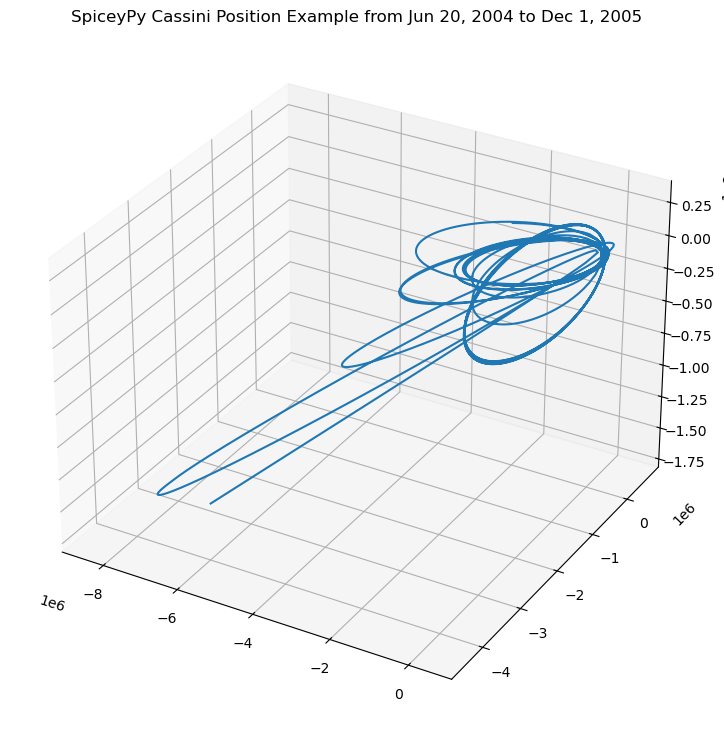

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

positions = (
    np.asarray(spqlpos).T
)  # positions is shaped (4000, 3), let's transpose to (3, 4000) for easier indexing
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")
ax.plot(positions[0], positions[1], positions[2])
plt.title("SpiceyPy Cassini Position Example from Jun 20, 2004 to Dec 1, 2005")
plt.show()